In [1]:
!pip install requests beautifulsoup4 boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.4 MB/s eta 0:00:00


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta, date
import re
import os
import boto3
from botocore.exceptions import ClientError, NoCredentialsError
from traceback import format_exc
import json
import traceback
import time
import pytz

После необходимых импортов прописываем данные для s3 сохранения ссылок на новости.

In [3]:
os.environ['AWS_ACCESS_KEY_ID'] = <access_key>
os.environ['AWS_SECRET_ACCESS_KEY'] = <secret_access_key>

BUCKET = 'russian-news'

access_key = os.getenv('AWS_ACCESS_KEY_ID')
secret_key = os.getenv('AWS_SECRET_ACCESS_KEY')
endpoint_url = 'https://storage.yandexcloud.net'

# Создание клиента S3
s3_client = boto3.client('s3',
                         region_name='ru-central1',
                         aws_access_key_id=access_key,
                         aws_secret_access_key=secret_key,
                         endpoint_url=endpoint_url)

Добавляем код для сохранения данных в s3

In [4]:
def upload_object_to_s3(date, body):
    key = f'ria/{date}.pkl'
    response = s3_client.put_object(Bucket=BUCKET, Key=key, Body=body)
    if response['ResponseMetadata']['HTTPStatusCode'] == 200:
        print(f"Успешно сохранен в {BUCKET}/{key}")
    else:
        print(f"Ошибка при сохранении: {response['ResponseMetadata']['HTTPStatusCode']}")

Прописываем функцию для получения страниц для каждого дня с 16 октября 2001 до настоящего. И по каждой странице получаем ссылки на статьи. Для следующего получения полных данных по каждой из ссылок.

In [5]:
def fetch_ria_news(start_date = datetime.strptime('2001-10-16', '%Y-%m-%d').date(), end_date = datetime.now(pytz.timezone('Europe/Moscow')).date()):
    from datetime import date, timedelta
    import time

    if end_date > datetime.now(pytz.timezone('Europe/Moscow')).date():
        return print('Дата окончания в будущем')
    if start_date > end_date:
        return print('Дата начала больше окончания')

    delta = timedelta(days=1)
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }

    find_date = end_date
    wait_time = 10
    while (find_date >= start_date):
        last_id = -1
        news_links = set()
        print(find_date)
        reg_date = re.sub('-', '', str(find_date))
        url = f'https://ria.ru/{reg_date}/'
        while True:
            response = requests.get(url, headers=headers)

            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
                divs = soup.find_all('div', class_='list-item__content')

                for div in divs:
                    links = div.find_all('a', href=True)
                    for link in links:
                        last_href = link['href']
                        if re.search(f'^https://ria.ru/{reg_date}/.+.*', last_href):
                            news_links.add(last_href)
                            href = last_href
                        else:
                            print(f'Плохие ссылки {last_href}')
            elif response.status_code == 429:
                print(f"По {url} получили {response.status_code} ждем секунду")
                time.sleep(wait_time)
                continue
            else:
                print(f"Ошибка при получении данных с {url}: {response.status_code}")
            next_date = soup.find_all('div', class_='list-item__info-item', attrs={'data-type': 'date'})
            if len(next_date) == 0:
                break
            date_time = re.sub(':', '', next_date[-1].text[-5:]) + '59'
            id = re.findall(r'(\d+)(?=\.html)', href)[-1]
            if id == last_id:
                break
            else:
                last_id = id
            url = f'https://ria.ru/services/{reg_date}/more.html?id={id}&date={reg_date}T{date_time}'
        print(f'Число сохраняемых ссылок: {len(news_links)}')
        try:
            upload_object_to_s3(find_date, json.dumps(list(news_links)))
        except ClientError as e:
            print(f"Произошла ошибка: {e.response['Error']['Message']}")
        except Exception as e:
            error_message = f"Неизвестная ошибка: {str(e)}"
            error_context = traceback.format_exc()
            print(f"{error_message}\nКонтекст ошибки:\n{error_context}")
        find_date -= delta

тестовый запуск

In [ ]:
fetch_ria_news(datetime.strptime('2025-01-02', '%Y-%m-%d').date(), datetime.strptime('2025-01-05', '%Y-%m-%d').date())

2025-01-05
Плохие ссылки /author_Strelnikov_Kirill/
Плохие ссылки /author_Strelnikov_Kirill/
Плохие ссылки /author_karaeva_elena/
Плохие ссылки /author_anastasiamelnikova/
Число сохраняемых ссылок: 309
Успешно сохранен в russian-news/ria/2025-01-05.pkl
2025-01-04
Плохие ссылки /author_Akopov_Petr/
Плохие ссылки /author_david_narmaniya/
Число сохраняемых ссылок: 282
Успешно сохранен в russian-news/ria/2025-01-04.pkl
2025-01-03
Плохие ссылки /author_Strelnikov_Kirill/
Плохие ссылки /author_savchuk/
Число сохраняемых ссылок: 331
Успешно сохранен в russian-news/ria/2025-01-03.pkl
2025-01-02
Плохие ссылки /author_krutikov_evgeniy/
Плохие ссылки /author_Strelnikov_Kirill/
Плохие ссылки /author_samofalova_olga/
Число сохраняемых ссылок: 271
Успешно сохранен в russian-news/ria/2025-01-02.pkl


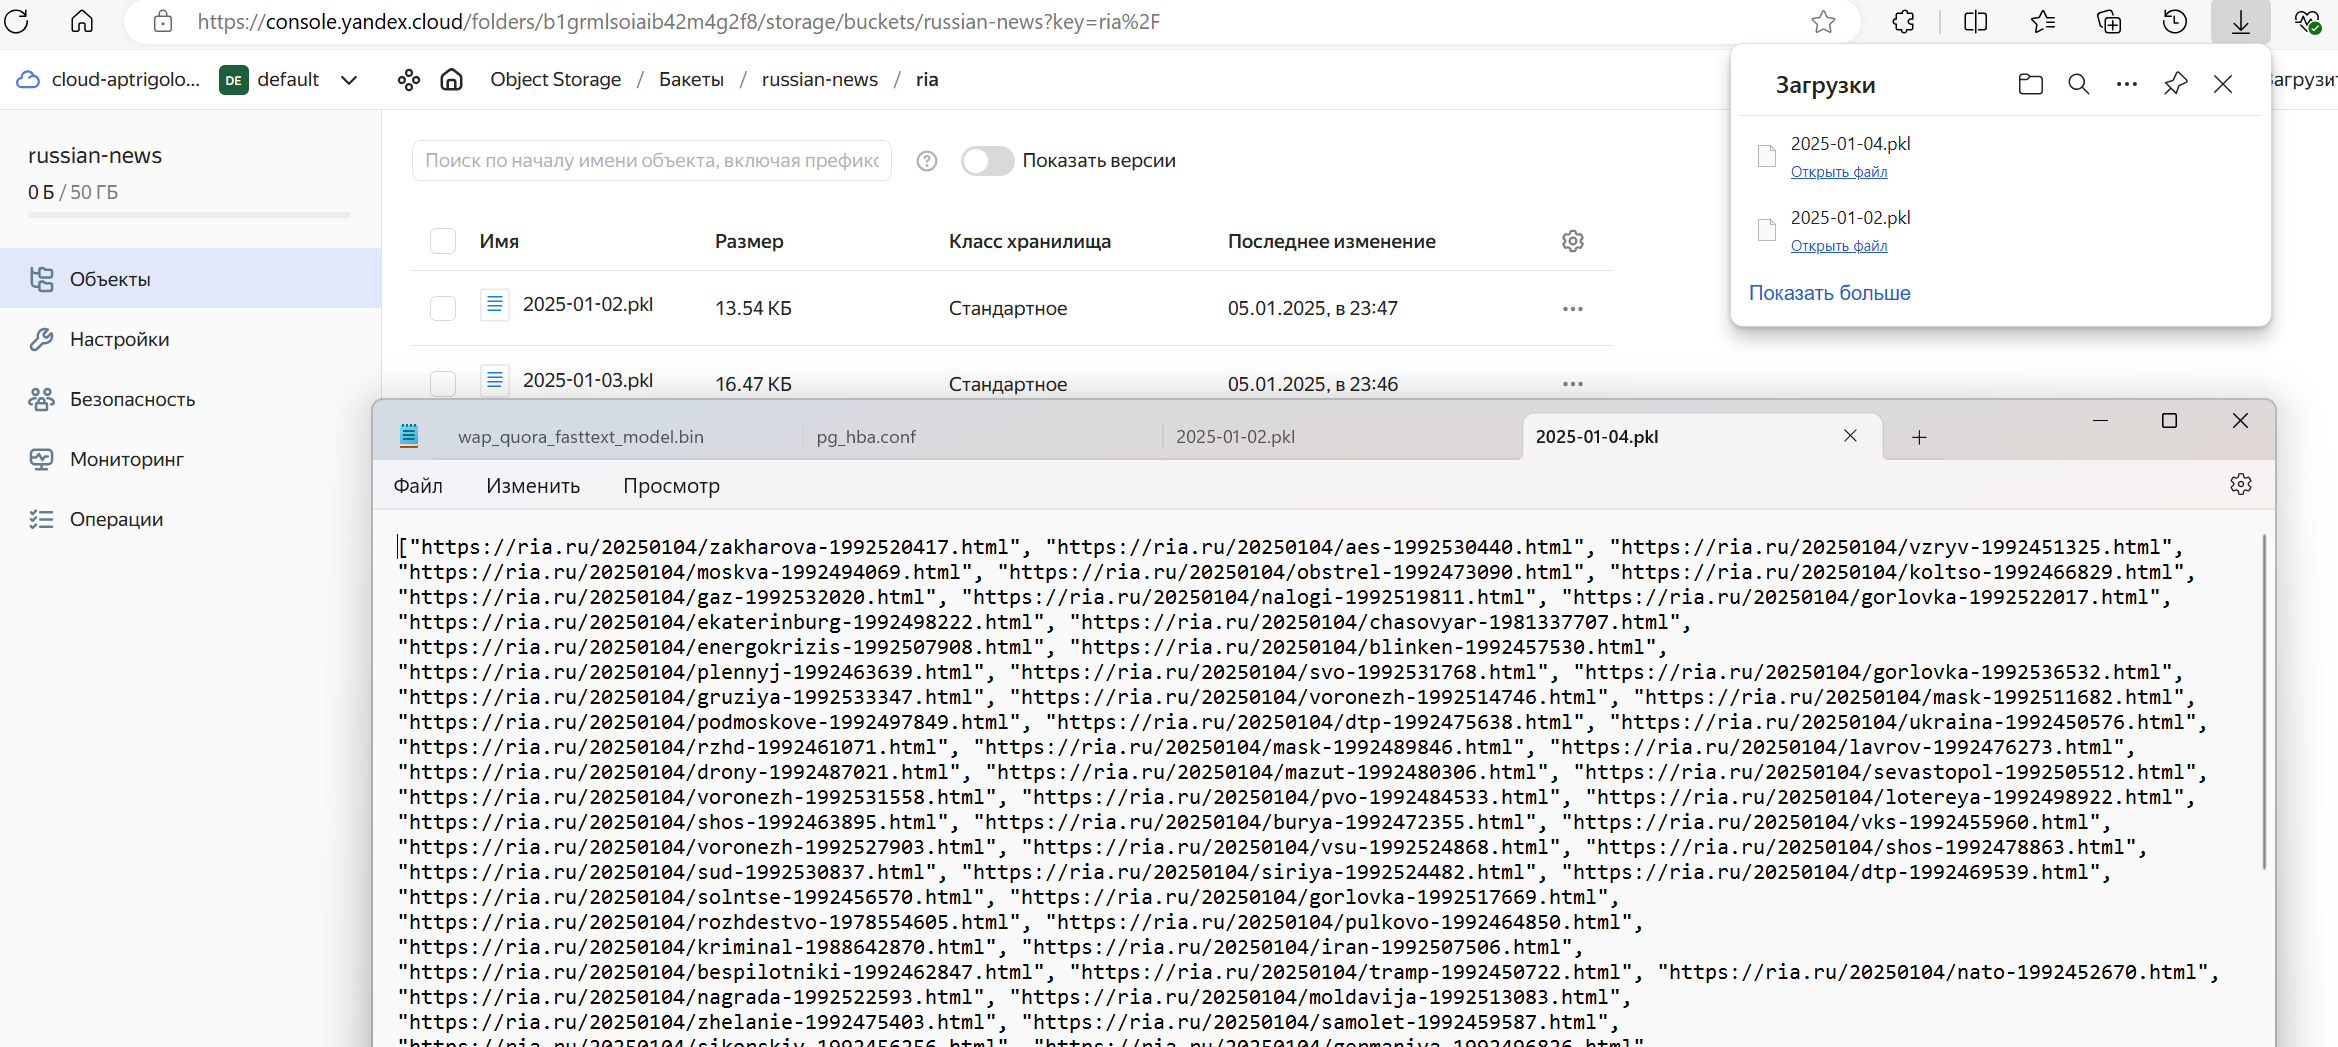

Теперь получаем все ссылки